In [5]:
from Helper import Helper

In [6]:
h = Helper("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip")

[]
2 -- 0 at 10_food_classes_10_percent
10 -- 0 at 10_food_classes_10_percent/train
0 -- 75 at 10_food_classes_10_percent/train/ramen
0 -- 75 at 10_food_classes_10_percent/train/ice_cream
0 -- 75 at 10_food_classes_10_percent/train/pizza
0 -- 75 at 10_food_classes_10_percent/train/chicken_wings
0 -- 75 at 10_food_classes_10_percent/train/grilled_salmon
0 -- 75 at 10_food_classes_10_percent/train/fried_rice
0 -- 75 at 10_food_classes_10_percent/train/steak
0 -- 75 at 10_food_classes_10_percent/train/hamburger
0 -- 75 at 10_food_classes_10_percent/train/chicken_curry
0 -- 75 at 10_food_classes_10_percent/train/sushi
10 -- 0 at 10_food_classes_10_percent/test
0 -- 250 at 10_food_classes_10_percent/test/ramen
0 -- 250 at 10_food_classes_10_percent/test/ice_cream
0 -- 250 at 10_food_classes_10_percent/test/pizza
0 -- 250 at 10_food_classes_10_percent/test/chicken_wings
0 -- 250 at 10_food_classes_10_percent/test/grilled_salmon
0 -- 250 at 10_food_classes_10_percent/test/fried_rice
0 -- 250 

In [7]:
class_names = h.get_classnames()

In [8]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

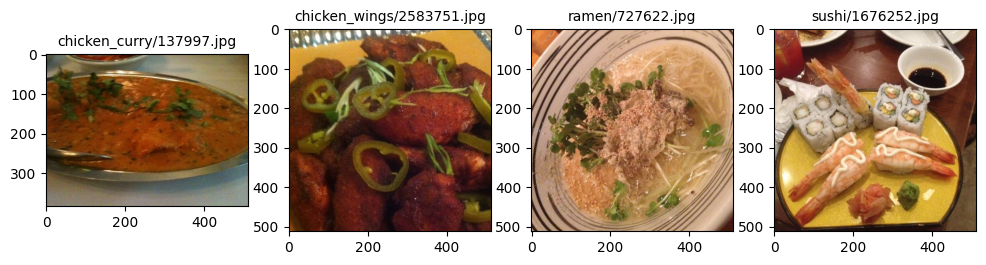

In [9]:
h.view_random_test_image()

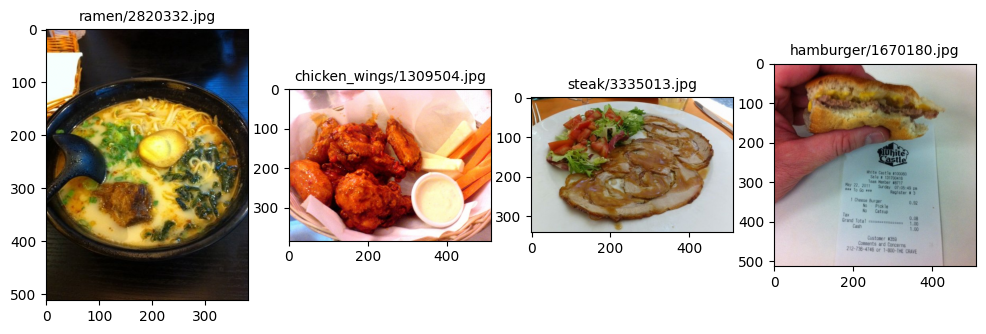

In [10]:
h.view_random_train_image()

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense , Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [12]:
# Importing the Data

BATCH_SIZE = 32
IMG_SIZE = (224,224)
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_data = tf.keras.utils.image_dataset_from_directory(

    directory=train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='categorical'

)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [13]:
len(train_data), len(test_data)

(24, 79)

In [14]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [15]:
test_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [16]:
import datetime
def create_callbacks(dir_name, exp_name):
  log_dir = dir_name + "/" + exp_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensor_callbacks = tf.keras.callbacks.TensorBoard(log_dir="./logs" )
  print(f"Dumping into the dir {log_dir}")
  return tensor_callbacks

## Setting Up a Model

In [17]:
tf.random.set_seed(42)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

24274472/24274472 [==============================] - 0s 0us/step


In [18]:
for layer_no , layer_name in enumerate(base_model.layers[:-5]):
  if layer_name.trainable == True : layer_name.trainable =  False

In [19]:
for layer_no , layer_name in enumerate(base_model.layers[:]):
  if layer_name.trainable == True:
    print(layer_no ,layer_name.name , layer_name.trainable)


265 block6h_drop True
266 block6h_add True
267 top_conv True
268 top_bn True
269 top_activation True


In [20]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="Input_Layer")


print("Shape of inputs  : ", inputs.shape)
## Add the input layer to base model



## Data Augmentation Layer

data_augmentaion_layer = Sequential(
    [
  layers.RandomFlip(mode='horizontal'),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomRotation(0.2)
  ]
)

X = data_augmentaion_layer(inputs)

print("Shape after aug layer  : ", X.shape)

X = base_model(X, training=False)

print("Shape after passing through base model  : ", X.shape)

X = tf.keras.layers.GlobalAveragePooling2D(name="Global_Avg_Pool_Layer") ( X ) # Getting rid of extra dimension

print("Shape after passing through Avg Pooling Layer  : ", X.shape)

outputs = tf.keras.layers.Dense(
    len(class_names),
    activation='softmax',
    name='Output_Layer'
) (X)

print("Shape after output layer : ", outputs.shape)

fine_tuned_model = tf.keras.Model( inputs , outputs)



Shape of inputs  :  (None, 224, 224, 3)
Shape after aug layer  :  (None, None, None, 3)
Shape after passing through base model  :  (None, None, None, 1280)
Shape after passing through Avg Pooling Layer  :  (None, 1280)
Shape after output layer :  (None, 10)


In [21]:
for layer_no , layer_name in enumerate(fine_tuned_model.layers):
  print(layer_no , layer_name.name , layer_name.trainable)
  if layer_name.name == "efficientnetv2-b0":
    for no , name in enumerate(layer_name.layers[-10:]):
      print('\t', 270 - 10 + no , name.name, name.trainable)

0 Input_Layer True
1 sequential True
2 efficientnetv2-b0 True
	 260 block6h_se_reduce False
	 261 block6h_se_expand False
	 262 block6h_se_excite False
	 263 block6h_project_conv False
	 264 block6h_project_bn False
	 265 block6h_drop True
	 266 block6h_add True
	 267 top_conv True
	 268 top_bn True
	 269 top_activation True
3 Global_Avg_Pool_Layer True
4 Output_Layer True


## Model Compilation

In [22]:
## Compilation of fine-tunned model

fine_tuned_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)

## Model Fitting

In [23]:
# Model Checkpoint
import numpy as np
create_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="10_percent_data_checkpoint/checkpoint.ckpt",
                                                             save_weights_only=True,
                                                             save_freq="epoch",
                                                             save_best_only = True,
                                                             verbose=1)


history1 = fine_tuned_model.fit((train_data),
                     epochs=10,
                     steps_per_epoch=len(train_data),
                     batch_size=BATCH_SIZE,
                     validation_data = (test_data),
                     validation_steps = int(1 * len(test_data)),
                     callbacks=[create_callbacks("EfficientNets", "10_per_data"), create_model_checkpoint]
                     )

Dumping into the dir EfficientNets/10_per_data_20231015-143933
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.1789 - accuracy: 0.2240
Epoch 1: val_loss improved from inf to 1.94648, saving model to 10_percent_data_checkpoint/checkpoint.ckpt
24/24 [==============================] - 45s 1s/step - loss: 2.1789 - accuracy: 0.2240 - val_loss: 1.9465 - val_accuracy: 0.3912
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.8754 - accuracy: 0.4600
Epoch 2: val_loss improved from 1.94648 to 1.62784, saving model to 10_percent_data_checkpoint/checkpoint.ckpt
24/24 [==============================] - 22s 865ms/step - loss: 1.8754 - accuracy: 0.4600 - val_loss: 1.6278 - val_accuracy: 0.6080
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.6317 - accuracy: 0.5933
Epoch 3: val_loss improved from 1.62784 to 1.37226, saving model to 10_percent_data_checkpoint/checkpoint.ckpt
24/24 [==============================] - 18s 758ms/step - loss: 1

In [27]:
len(train_data) \
,len(class_names)

(24, 10)

In [28]:
[_.name for _ in  fine_tuned_model.layers[2].layers ]

['input_1',
 'rescaling',
 'normalization',
 'stem_conv',
 'stem_bn',
 'stem_activation',
 'block1a_project_conv',
 'block1a_project_bn',
 'block1a_project_activation',
 'block2a_expand_conv',
 'block2a_expand_bn',
 'block2a_expand_activation',
 'block2a_project_conv',
 'block2a_project_bn',
 'block2b_expand_conv',
 'block2b_expand_bn',
 'block2b_expand_activation',
 'block2b_project_conv',
 'block2b_project_bn',
 'block2b_drop',
 'block2b_add',
 'block3a_expand_conv',
 'block3a_expand_bn',
 'block3a_expand_activation',
 'block3a_project_conv',
 'block3a_project_bn',
 'block3b_expand_conv',
 'block3b_expand_bn',
 'block3b_expand_activation',
 'block3b_project_conv',
 'block3b_project_bn',
 'block3b_drop',
 'block3b_add',
 'block4a_expand_conv',
 'block4a_expand_bn',
 'block4a_expand_activation',
 'block4a_dwconv2',
 'block4a_bn',
 'block4a_activation',
 'block4a_se_squeeze',
 'block4a_se_reshape',
 'block4a_se_reduce',
 'block4a_se_expand',
 'block4a_se_excite',
 'block4a_project_conv'

In [29]:
len(train_data)

24

In [32]:
fine_tuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Global_Avg_Pool_Layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 Output_Layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 261130 (10

In [31]:
len(train_data)
# in093759

24

In [30]:
import matplotlib.pyplot as plt
def plot_the_graph(hist):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.title("Accuracy vs Val Accuracy")
  plt.plot(hist.history['accuracy'], label="accuracy")
  plt.plot(hist.history['val_accuracy'], label='val_accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title('Loss vs Val Loss')
  plt.plot(hist.history['loss'], label="loss")
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.legend()

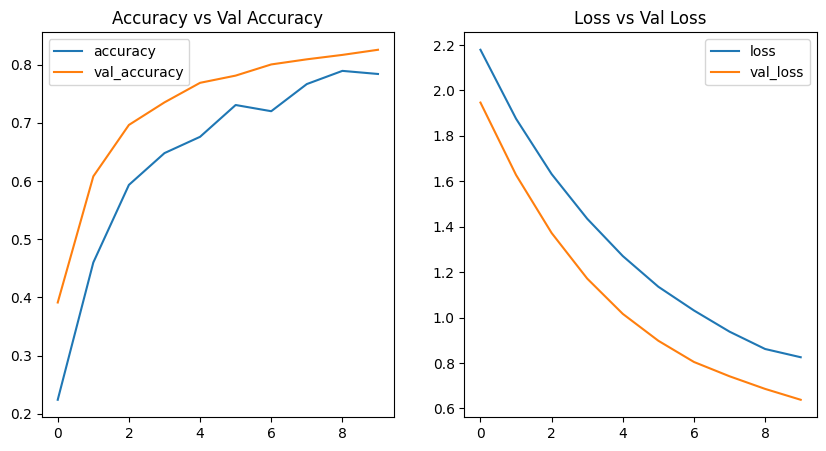

In [33]:
plot_the_graph(history1)

### Predicting the Model

In [34]:
pred_pos = fine_tuned_model.predict(test_data, verbose=1)

79/79 [==============================] - 8s 86ms/step


In [35]:
import numpy as np

In [36]:
pred_pos, pred_pos.shape

(array([[0.4585476 , 0.01817149, 0.01483731, ..., 0.37078342, 0.03458958,
         0.00572614],
        [0.55245334, 0.01426527, 0.01978372, ..., 0.33001977, 0.01101171,
         0.00710583],
        [0.6441292 , 0.00684619, 0.0080351 , ..., 0.25995195, 0.00491911,
         0.00834913],
        ...,
        [0.01033554, 0.0255768 , 0.01619584, ..., 0.00498485, 0.00661258,
         0.7854001 ],
        [0.01250538, 0.01864672, 0.01867328, ..., 0.00280674, 0.08187589,
         0.23599246],
        [0.00911454, 0.08093268, 0.00730901, ..., 0.00348734, 0.19700304,
         0.47969034]], dtype=float32),
 (2500, 10))

In [37]:
pred_pos[:10]

array([[4.58547592e-01, 1.81714855e-02, 1.48373125e-02, 8.96112844e-02,
        4.64350265e-03, 1.39888970e-03, 1.69086445e-03, 3.70783418e-01,
        3.45895812e-02, 5.72613813e-03],
       [5.52453339e-01, 1.42652718e-02, 1.97837166e-02, 2.12335568e-02,
        1.20591307e-02, 2.62920428e-02, 5.77559788e-03, 3.30019772e-01,
        1.10117104e-02, 7.10582826e-03],
       [6.44129217e-01, 6.84619276e-03, 8.03510379e-03, 1.01250829e-02,
        1.63043067e-02, 1.34118255e-02, 2.79281046e-02, 2.59951949e-01,
        4.91910847e-03, 8.34912900e-03],
       [3.67524326e-01, 2.41516586e-02, 7.75914639e-02, 2.17598930e-01,
        8.84438530e-02, 5.35653485e-03, 1.79572832e-02, 1.56591043e-01,
        2.02855244e-02, 2.44993307e-02],
       [2.51318842e-01, 1.30475359e-02, 1.58596024e-01, 3.62620860e-01,
        3.14050727e-02, 9.44202300e-03, 7.24897236e-02, 2.54779682e-02,
        2.74818372e-02, 4.81201410e-02],
       [7.31432796e-01, 3.14571941e-03, 1.39887352e-02, 3.34667936e-02,
   

In [38]:
import random as rd
print("Predicted For Images  ", len(pred_pos))
print('Predicted Data : ', pred_pos)
print(f'Random Pred Data', pred_pos[rd.randint(0, len(pred_pos) - 1 )])

Predicted For Images   2500
Predicted Data :  [[0.4585476  0.01817149 0.01483731 ... 0.37078342 0.03458958 0.00572614]
 [0.55245334 0.01426527 0.01978372 ... 0.33001977 0.01101171 0.00710583]
 [0.6441292  0.00684619 0.0080351  ... 0.25995195 0.00491911 0.00834913]
 ...
 [0.01033554 0.0255768  0.01619584 ... 0.00498485 0.00661258 0.7854001 ]
 [0.01250538 0.01864672 0.01867328 ... 0.00280674 0.08187589 0.23599246]
 [0.00911454 0.08093268 0.00730901 ... 0.00348734 0.19700304 0.47969034]]
Random Pred Data [0.5106702  0.01560669 0.00764853 0.04742784 0.00511157 0.00290155
 0.00117837 0.38546243 0.01749197 0.00650087]


In [39]:
out = np.argmax(pred_pos, axis=1)

In [40]:
import os
print(sorted(os.listdir(train_dir)))

['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


In [41]:
# fine_tuned_model.predict(train_data[0])
output_images = []
output_labels = []
for images,labels in test_data.unbatch():
  output_images.append(images)
  output_labels.append(labels)



In [ ]:
## Visualization of Predicted  Data
import os
def visualize_the_pred(out,output_images, output_labels):
  sel = rd.randint(0, len(out) - 1)
  pred = model.predict()
  output = sorted(os.listdir(train_dir))[pred]

  plt.title(output)


In [ ]:
np.argmax(pred_pos[100])